In [5]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image


# Function to calculate cosine similarity between two vectors
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

# Function to find similar images and plot them
def find_and_plot_similar_images(image_path, top_k=5):
    # Load the query image and extract its embeddings
    query_embeddings = get_image_embeddings(image_path)

    # Connect to Neo4j
    uri = "bolt://localhost:7687"
    username = "neo4j"
    password = "password"
    
    query_embeddings = list(query_embeddings)
    print('query embedding type',type(query_embeddings))
    # Define the Neo4j query to find similar images
    query = (
        """
    MATCH (a:Image)
    WITH a, gds.similarity.cosine(a.embeddings, $query_embeddings) AS similarity
    ORDER BY similarity DESC
    LIMIT $top_k
    RETURN a.id AS image_id, a.embeddings AS embeddings, a.path as image_path, similarity
    """
    )

    # Execute the query
    with GraphDatabase.driver(uri, auth=(username, password)) as driver:
        with driver.session() as session:
            result = session.run(query, query_embeddings=query_embeddings, top_k=3)

            # Initialize lists to store image IDs and similarities
            image_ids = []
            similarities = []
            print(result)
            for record in result:
                image_ids.append(record["image_path"])
                embeddings = record["embeddings"]
                similarity = record["similarity"]
                similarities.append(similarity)

            # Plot similar images
            plot_similar_images(image_path, image_ids, similarities)

# Function to plot similar images
def plot_similar_images(query_image_path, image_ids, similarities):
    fig, axes = plt.subplots(1, len(image_ids) + 1, figsize=(15, 5))
    
    # Plot the query image
    query_image = Image.open(query_image_path)
    axes[0].imshow(query_image)
    axes[0].set_title("Query Image")
    axes[0].axis("off")
    
    # Plot similar images
    for i, (image_id, similarity) in enumerate(zip(image_ids, similarities)):
        similar_image_path = image_id #f"similar_images/{image_id}.jpg"  # Adjust the path to your image directory
        similar_image = Image.open(similar_image_path)
        axes[i + 1].imshow(similar_image)
        axes[i + 1].set_title(f"Similarity: {similarity:.2f}")
        axes[i + 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Function to get image embeddings (replace with your image embedding function)
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to get image embeddings
def get_image_embeddings(image_path):
    img = Image.open(image_path).convert('RGB')
    img = preprocess(img)
    img = img.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embeddings = model(img)
    return embeddings.squeeze().numpy()
# if __name__ == "__main__":
#     input_image_path = "input.jpg"  # Path to your input image
#     find_and_plot_similar_images(input_image_path)


c:\Users\vivek\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vivek\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


query embedding type <class 'list'>


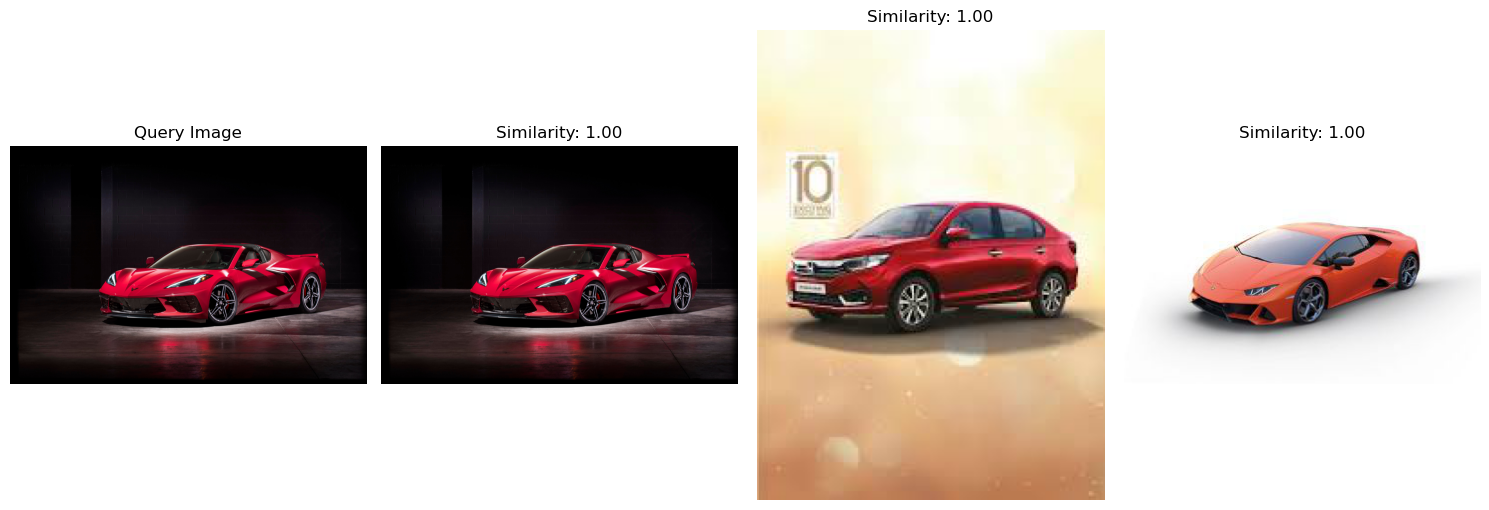

In [6]:
find_and_plot_similar_images("data/images/0x0.jpg")